In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import linprog
from portfolio_optimizer import PortfolioOptimizer
import warnings
from portfolio_optimizer_v2 import PortfolioOptimizerV2

import pandas_datareader

Fetched data for: {'IWDA.AS': '^990100-USD-STRD', 'VAGF.DE': 'VBTLX', 'IGLN.L': 'IAU'}
Price history from 2005-01-28 to 2026-02-12


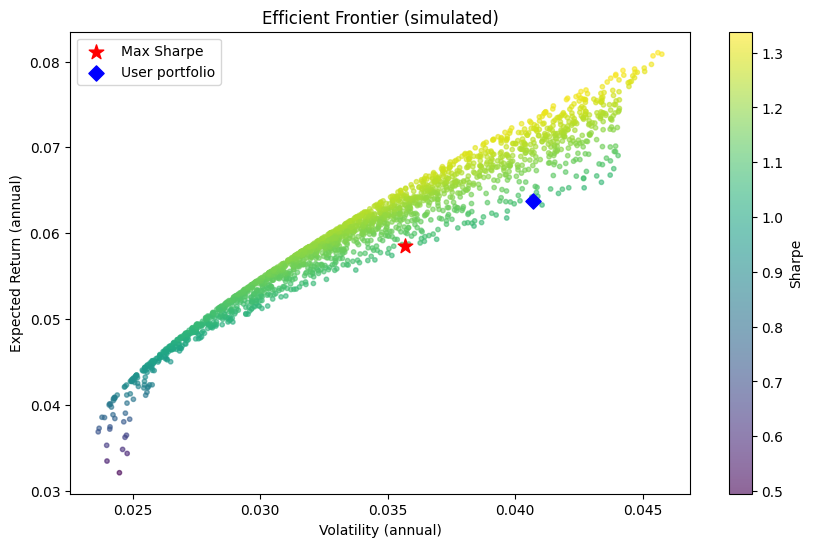

In [2]:
if __name__ == "__main__":
    # original tickers
    user_tickers = ["IWDA.AS", "VAGF.DE", "IGLN.L"]

    # Proxy map: use long-history proxies where possible (Yahoo tickers)
    proxy_map = {
        "IWDA.AS": "^990100-USD-STRD",  # MSCI WORLD historical series
        "VAGF.DE": "VBTLX",             # Vanguard Total Bond Market mutual fund
        "IGLN.L": "IAU"                 # Gold ETF with longer history
    }

    opt = PortfolioOptimizerV2(user_tickers, start_date='1990-01-01', end_date=None, freq='1d',
                               risk_free_rate=0.02, inflation=0.02)

    opt.fetch_data(proxy_map=proxy_map)

    # Use geometric (CAGR) nominal returns
    mu_geo = opt.get_expected_returns(method='geometric', deflate_inflation=False)
    #print("Geometric (annual) returns (nominal):\n", mu_geo)

    # Optionally deflate
    mu_real = opt.get_expected_returns(method='geometric', deflate_inflation=True)
    #print("Geometric (annual) returns (real, deflated by inflation):\n", mu_real)

    # Shrink means toward economic prior (example prior in nominal terms)
    # Prior order should match opt.tickers; e.g., [equities, bonds, gold] nominal
    example_prior = np.array([0.065, 0.025, 0.025])  # 6.5% equities, 2.5% bonds, 2.5% gold
    opt.shrink_means(prior=example_prior, lam=0.4)

    # Shrink covariance
    opt.shrink_covariance(delta=0.2, prior_type='single_factor')

    # Optimize with bounds similar to your original (force gold <= 5%)
    bounds = [(0.1, 0.95), (0.1, 0.95), (0.0, 0.05)]
    w_opt, perf_opt = opt.optimize_sharpe(bounds=bounds)
    #print("Max Sharpe weights:", w_opt)
    #print("Performance (r, vol, sharpe):", perf_opt)

    # Simulate efficient frontier and plot
    opt.simulate_efficient_frontier(num_portfolios=2000)
    user_weights = [0.85, 0.10, 0.05]
    opt.plot_efficient_frontier(user_weights=user_weights, user_label='User portfolio')


        # Only suppress RuntimeWarnings in this block
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        bt_returns, bt_weights = opt.rolling_backtest(
            window=252*3,  # 3-year training window
            rebalance_freq=21,  # monthly-ish rebalance
            method='sharpe',
            bounds=bounds,
            shrink_mean={'prior': example_prior, 'lam': 0.4},
            shrink_cov={'delta': 0.2, 'prior_type': 'single_factor'}
        )
  
    ann_ret, ann_vol, sharpe, maxdd = opt.backtest_stats()
    #print("Backtest stats (annualized):", ann_ret, ann_vol, sharpe, "maxDD:", maxdd)

In [3]:
# Portfolio weights
w_table = pd.DataFrame({
    "Asset": opt.tickers,
    "Weight": np.round(w_opt, 4),
    "Exp Return (nominal)": np.round(mu_geo[opt.tickers], 4),
    "Exp Return (real)": np.round(mu_real[opt.tickers], 4)
})

# Portfolio-level stats
r, vol, sharpe = perf_opt
ann_ret, ann_vol, bt_sharpe, maxdd = opt.backtest_stats()

perf_table = pd.DataFrame({
    "Metric": [
        "Optimized Portfolio Return (nominal)",
        "Optimized Portfolio Volatility",
        "Optimized Portfolio Sharpe",
        "Backtest Annual Return",
        "Backtest Annual Volatility",
        "Backtest Sharpe",
        "Backtest Max Drawdown"
    ],
    "Value": [
        round(r, 4),
        round(vol, 4),
        round(sharpe, 4),
        round(ann_ret, 4),
        round(ann_vol, 4),
        round(bt_sharpe, 4),
        round(maxdd, 4)
    ]
})

# Print nicely
print("\n--- Asset Weights & Expected Returns ---")
print(w_table.to_string(index=False))

print("\n--- Portfolio Performance & Backtest Stats ---")
print(perf_table.to_string(index=False))


--- Asset Weights & Expected Returns ---
  Asset  Weight  Exp Return (nominal)  Exp Return (real)
IWDA.AS  0.7089                0.0677             0.0477
VAGF.DE  0.2411                0.0332             0.0132
 IGLN.L  0.0500                0.1213             0.1013

--- Portfolio Performance & Backtest Stats ---
                              Metric   Value
Optimized Portfolio Return (nominal)  0.0586
      Optimized Portfolio Volatility  0.0357
          Optimized Portfolio Sharpe  1.0811
              Backtest Annual Return  0.0675
          Backtest Annual Volatility  0.0905
                     Backtest Sharpe  0.5246
               Backtest Max Drawdown -0.2592


In [14]:
## checking the tickers
ticker = "IAU"

df = yf.download(
    ticker,
    start="1900-01-01",   # safely before any modern index
    end=pd.Timestamp.today().strftime("%Y-%m-%d"),
    auto_adjust=False,
    progress=False
)

print("First date:", df.index.min())
print("Last date:", df.index.max())
print("Number of rows:", len(df))

print("\nColumns:")
print(df.columns)

print("\nHead:")
print(df.head())

print("\nTail:")
print(df.tail())

First date: 2005-01-28 00:00:00
Last date: 2026-02-11 00:00:00
Number of rows: 5293

Columns:
MultiIndex([('Adj Close', 'IAU'),
            (    'Close', 'IAU'),
            (     'High', 'IAU'),
            (      'Low', 'IAU'),
            (     'Open', 'IAU'),
            (   'Volume', 'IAU')],
           names=['Price', 'Ticker'])

Head:
Price      Adj Close  Close   High    Low   Open   Volume
Ticker           IAU    IAU    IAU    IAU    IAU      IAU
Date                                                     
2005-01-28     8.538  8.538  8.546  8.492  8.546  2888500
2005-01-31     8.454  8.454  8.462  8.398  8.446   759500
2005-02-01     8.424  8.424  8.428  8.394  8.422   347500
2005-02-02     8.446  8.446  8.446  8.408  8.446  1496500
2005-02-03     8.344  8.344  8.348  8.302  8.316   534000

Tail:
Price       Adj Close      Close       High        Low       Open    Volume
Ticker            IAU        IAU        IAU        IAU        IAU       IAU
Date                             

In [17]:
# Any gaps?
print("NaN counts:\n", df.isna().sum())

# Daily coverage per year
years = df.index.year.value_counts().sort_index()
print("\nObservations per year:\n", years.head(), "\n...\n", years.tail())

NaN counts:
 Price      Ticker
Adj Close  IAU       0
Close      IAU       0
High       IAU       0
Low        IAU       0
Open       IAU       0
Volume     IAU       0
dtype: int64

Observations per year:
 Date
2005    234
2006    251
2007    251
2008    253
2009    252
Name: count, dtype: int64 
...
 Date
2022    251
2023    250
2024    252
2025    250
2026     28
Name: count, dtype: int64


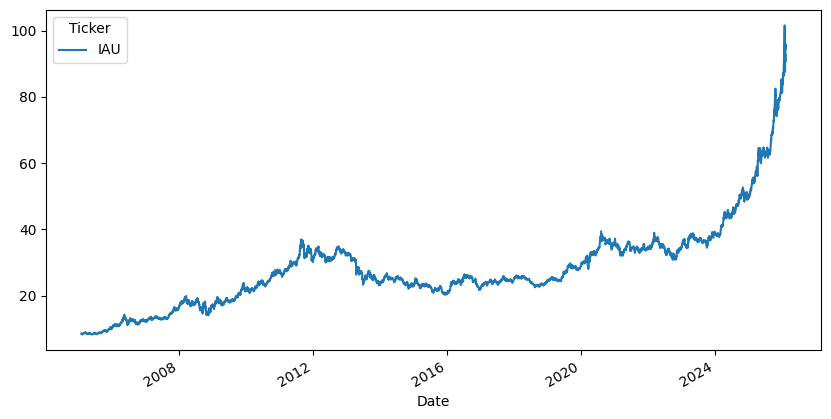

In [16]:
df['Adj Close'].plot(figsize=(10,5));